# Setup

## Load Libraries

In [3]:
library(tidyverse)
library(data.table)
library(broom)
library(dtplyr)
library(lme4) #for lmer & glmer models
library(lmerTest)
library(ggbeeswarm)
library(cowplot)
library(leaflet) # for maps
library(psych)
library(corrplot)
library(sjPlot) 
library(rstanarm)

── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘psych’


The following objects are masked from ‘packa

## Load Data

In [4]:
load('../../3_1_2_processed_data/VIB_measure_cleaned_data2021-11-30.RData')

This loads:

- `q_df` | the full Qualtrics dataframe with text responses
- `qn_df` | full Qualtrics dataframe with numeric responses
- `q_df1` | First run on SONA
- `ib_measures_df` | Intention behavior gap measures
- `eisen_quad` | Eisenhower quadrant values
- `validation_measures` | Individual difference questionnaires
- `scaled_domains_long` | Long df of subject scores in each domain
- `prescreen` | SONA prescreen info 

# Analyses

In [5]:
names(demographics)

[1] "subjectID"            "StartDate"            "LocationLatitude"    
 [4] "LocationLongitude"    "gender"               "age"                 
 [7] "education"            "ethnicity"            "father_education"    
[10] "mother_education"     "marital_status"       "employment_status"   
[13] "children_1"           "income"               "parents_income"      
[16] "net_worth"            "parents_net_worth"    "housing_status"      
[19] "macarthur_sss"        "macarthur_sss_parent" "job"                 
[22] "accomplishments"      "accomp_score"         "weight"              
[25] "height"               "bmi"                  "sat_score"           
[28] "gre_score_verbal"     "gre_score_quant"      "gpa_highschool"      
[31] "gpa_undergrad"

## Outcomes ~ Domains

### Radar Plots

In [6]:
library(fmsb)

Radar plots show a plot for each domain that shows its relationship with the outcome variables.

Outcome variables are:

- `bmi`
- `macarthur_sss`
- `macarthur_sss_parent`
- `accomp_score`
- `gpa_highschool`
- `self_esteem_single_1`
- `swl_cantril_ladder`

The relationship is defined by the $\beta$ value associated with the domain predicting the outcome variable.

The plots share the same $y$-axis, so can be compared across plots.

The values represent the magnitude of the effect size (regardless of sign).

In [247]:
outcome_vars = c('bmi', 'macarthur_sss', 'macarthur_sss_parent', 'accomp_score', 'gpa_highschool', 'self_esteem_single_1', 'swl_cantril_ladder')

In [248]:
outcomes_1 = demographics %>%
    as_tibble() %>%
    select(subjectID, all_of(outcome_vars[1:5]))

outcomes_2 = validation_measures %>%
    as_tibble() %>%
    select(subjectID, self_esteem_single_1, swl_cantril_ladder)

In [249]:
# create df that combines domain gaps with outocmes
df = merge(scaled_domains_long, outcomes_1, by = 'subjectID')

# then add in self esteem and swl
df = merge(df, outcomes_2, by = 'subjectID')

In [250]:
head(df, 3)

,subjectID,domain_num,domains_specific,domains_success,domains_satis,domains_import,domains_style,domains_internal,domains_external,domains_gapcause,⋯,w_domain_gap,domain_names,domain_names_short,bmi,macarthur_sss,macarthur_sss_parent,accomp_score,gpa_highschool,self_esteem_single_1,swl_cantril_ladder
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,1,1,4,5.5,5.5,1.25,5.5,5.5,5.5,5.5,⋯,1.875,Diet,Diet,24.37878,8,6,3,11,6,9
2,1,18,7,4.0,5.5,1.50,7.0,4.0,4.0,5.5,⋯,4.500,Cleaning,Cleaning,24.37878,8,6,3,11,6,9
3,1,5,7,5.5,7.0,1.00,7.0,5.5,5.5,5.5,⋯,1.500,Sleep,Sleep,24.37878,8,6,3,11,6,9


In [251]:
# number of domains
num_domains = max(scaled_domains_long$domain_num)

In [252]:
# create empty df
df_radar <- data.frame(matrix(ncol = length(outcome_vars), nrow = length(unique(df$domain_num))))
colnames(df_radar) <- outcome_vars

In [253]:
# loop through domains
for (i in 1:length(unique(df$domain_num))){

    # loop through outcomes
    for (j in 1:length(outcome_vars)){

        # set up lm equation
        f = paste("scale(as.numeric(", outcome_vars[j], "))", "~ scale(w_domain_gap)")
        
        # get standardized beta coefficient
        df_radar[i, j] = abs(lm(f, data = df[df$domain_num==i, ])$coefficients[[2]])
        # name row
        rownames(df_radar)[i] = df[df$domain_num==i, ]$domain_names_short[1] 
        
    }
}

In [254]:
head(df_radar, 3)

,bmi,macarthur_sss,macarthur_sss_parent,accomp_score,gpa_highschool,self_esteem_single_1,swl_cantril_ladder
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,0.05572838,0.15293076,0.06046989,0.02401013,0.1738219,0.2004617,0.3059170
Exercise,0.14798234,0.08381195,0.16283573,0.03584671,0.0865828,0.3299263,0.2314051
Mental Health,0.09729685,0.01150535,0.10244039,0.14136081,0.1762192,0.3722022,0.1731472


In [255]:
# rename columns
colnames(df_radar) = c('BMI', 'SSS', 'SSS.Parent', 'Accomp', 'GPA.HS', 'Self.Esteem', 'SWL')

In [257]:
max(df_radar)

[1] 0.4513626

In [262]:
mean(df_radar$SWL)

[1] 0.1267555

In [267]:
# Define the variable ranges: maximum and minimum
max_min <- data.frame(
    BMI = c(.5, 0), SSS = c(.5, 0), "SSS Parent" = c(.5, 0),
    Accomp = c(.5, 0), `GPA HS` = c(.5, 0), 
    Self.Esteem = c(.5, 0), SWL = c(.5, 0)
)

# Calculate the average profile 
col_mean <- apply(df_radar, 2, mean)
df <- rbind(max_min, col_mean)
rownames(df) <- c("Max", "Min", "Average")


# Bind the variable ranges and average to the data
df = rbind(df, df_radar)
head(df, 4)

,BMI,SSS,SSS.Parent,Accomp,GPA.HS,Self.Esteem,SWL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Max,0.50000000,0.5000000,0.50000000,0.50000000,0.5000000,0.5000000,0.5000000
Min,0.00000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000
Average,0.09144943,0.1124550,0.09949103,0.07845665,0.1327149,0.2449922,0.1267555
Diet,0.05572838,0.1529308,0.06046989,0.02401013,0.1738219,0.2004617,0.3059170


In [259]:
create_beautiful_radarchart <- function(data, color = "#00AFBB", 
                                        vlabels = colnames(data), vlcex = 0.7,
                                        caxislabels = NULL, title = NULL, ...){
  radarchart(
    data, axistype = 1,
    # Customize the polygon
    pcol = color, pfcol = scales::alpha(color, 0.5), plwd = 2, plty = 1,
    # Customize the grid
    cglcol = "grey", cglty = 1, cglwd = 0.8,
    # Customize the axis
    axislabcol = "grey", 
    # Variable labels
    vlcex = vlcex, vlabels = vlabels,
    caxislabels = caxislabels, title = title, ...
  )
}

#### Single

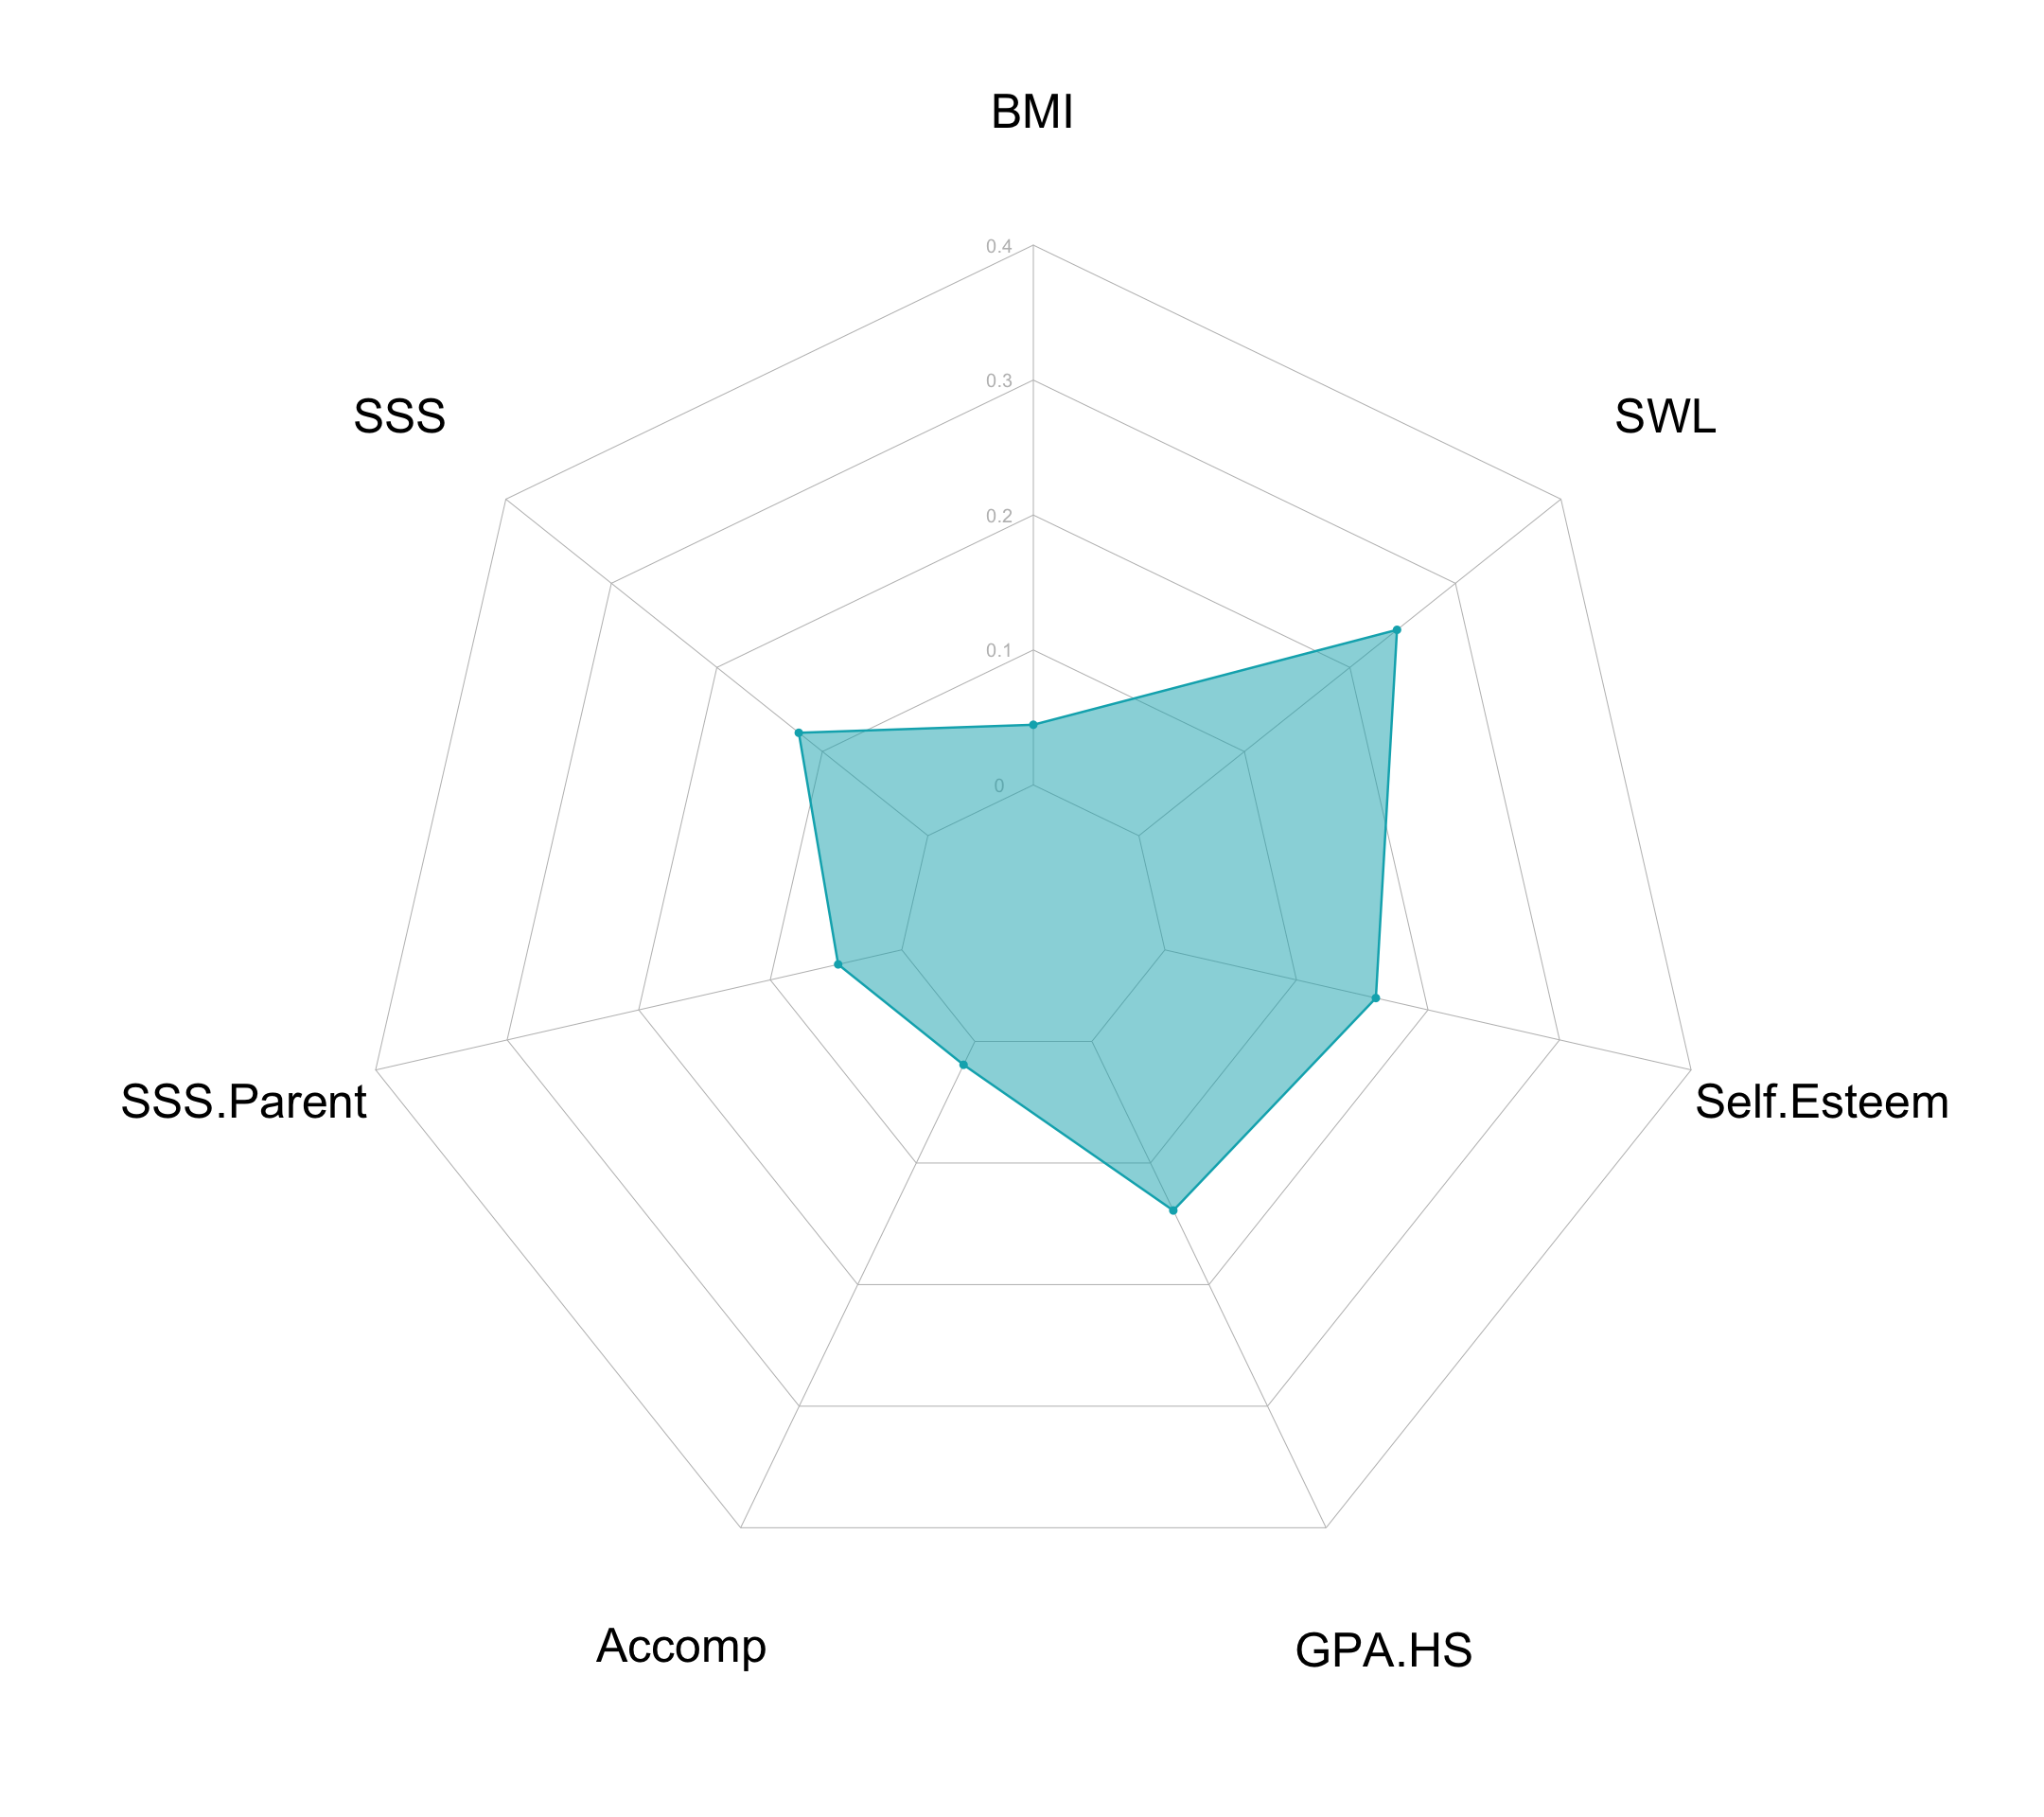

In [260]:
# Reduce plot margin using par()
op <- par(mar = c(1, 2, 2, 1))
create_beautiful_radarchart(df[1:3, ], caxislabels = c(0, 0.1, 0.2, 0.3, 0.4, 0.5),
                           vlcex = 2.5)
par(op)

#### All

In [269]:
mean(df_radar$Self.Esteem)

[1] 0.2449922

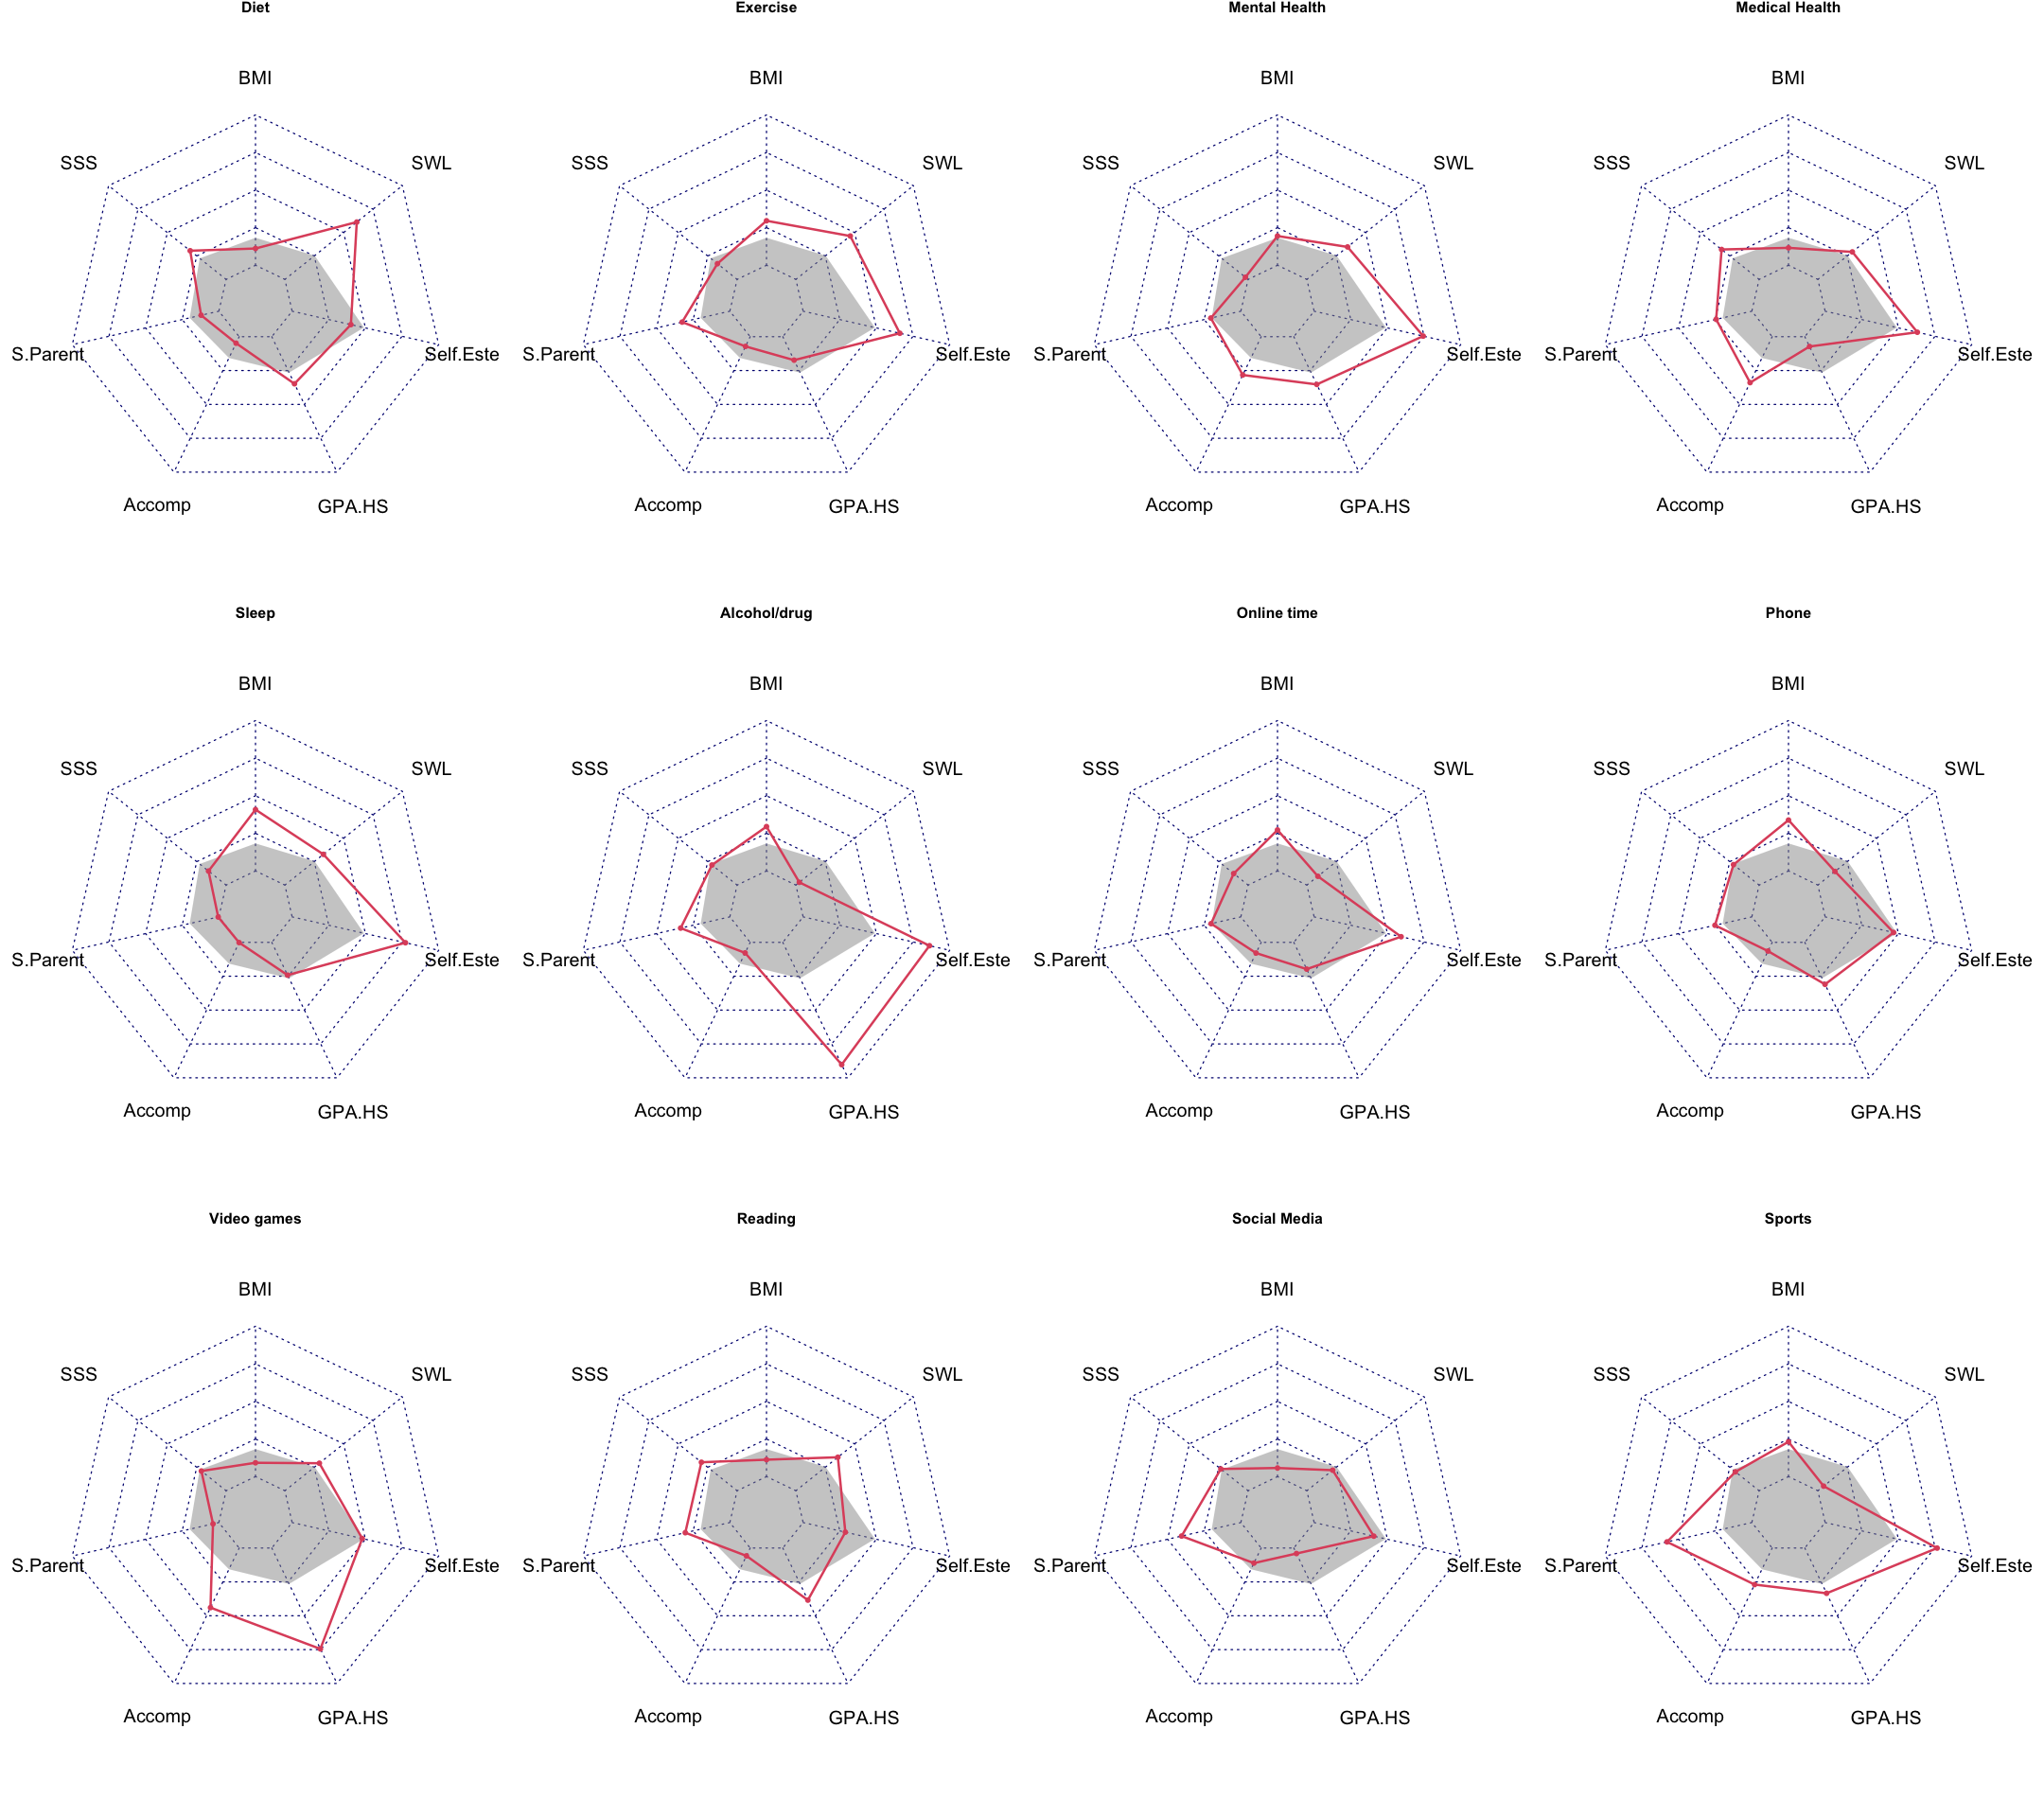

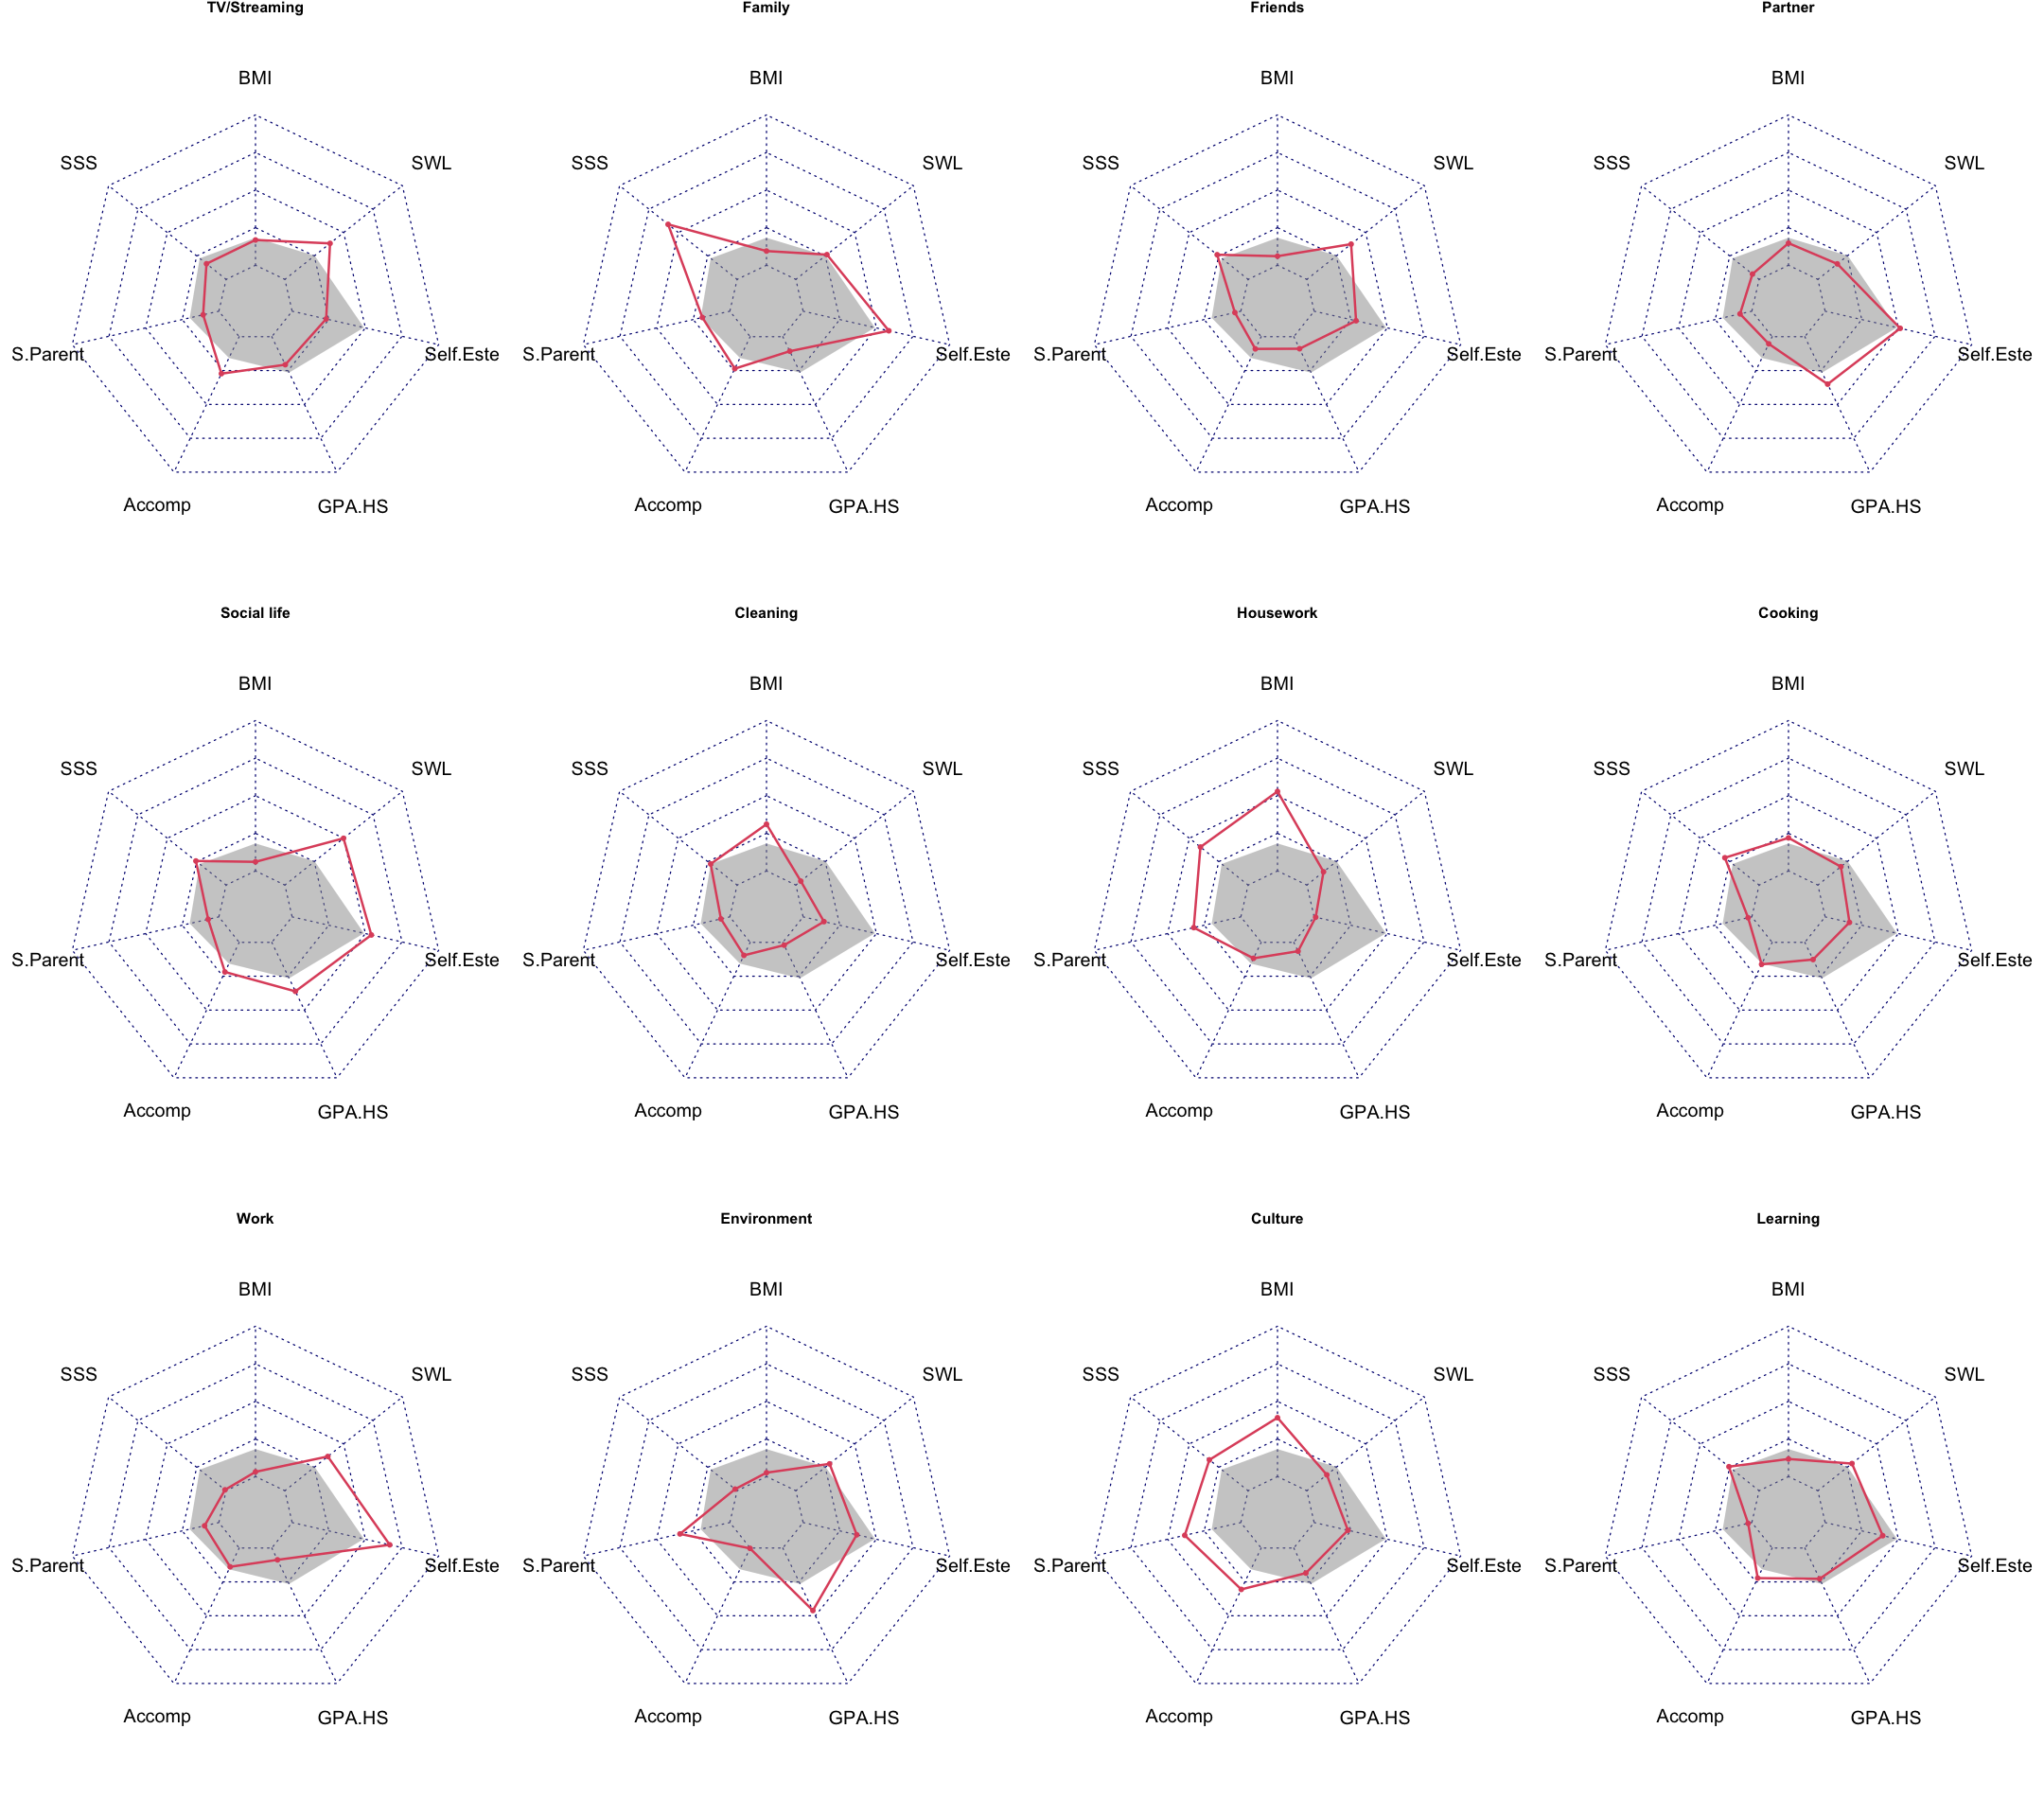

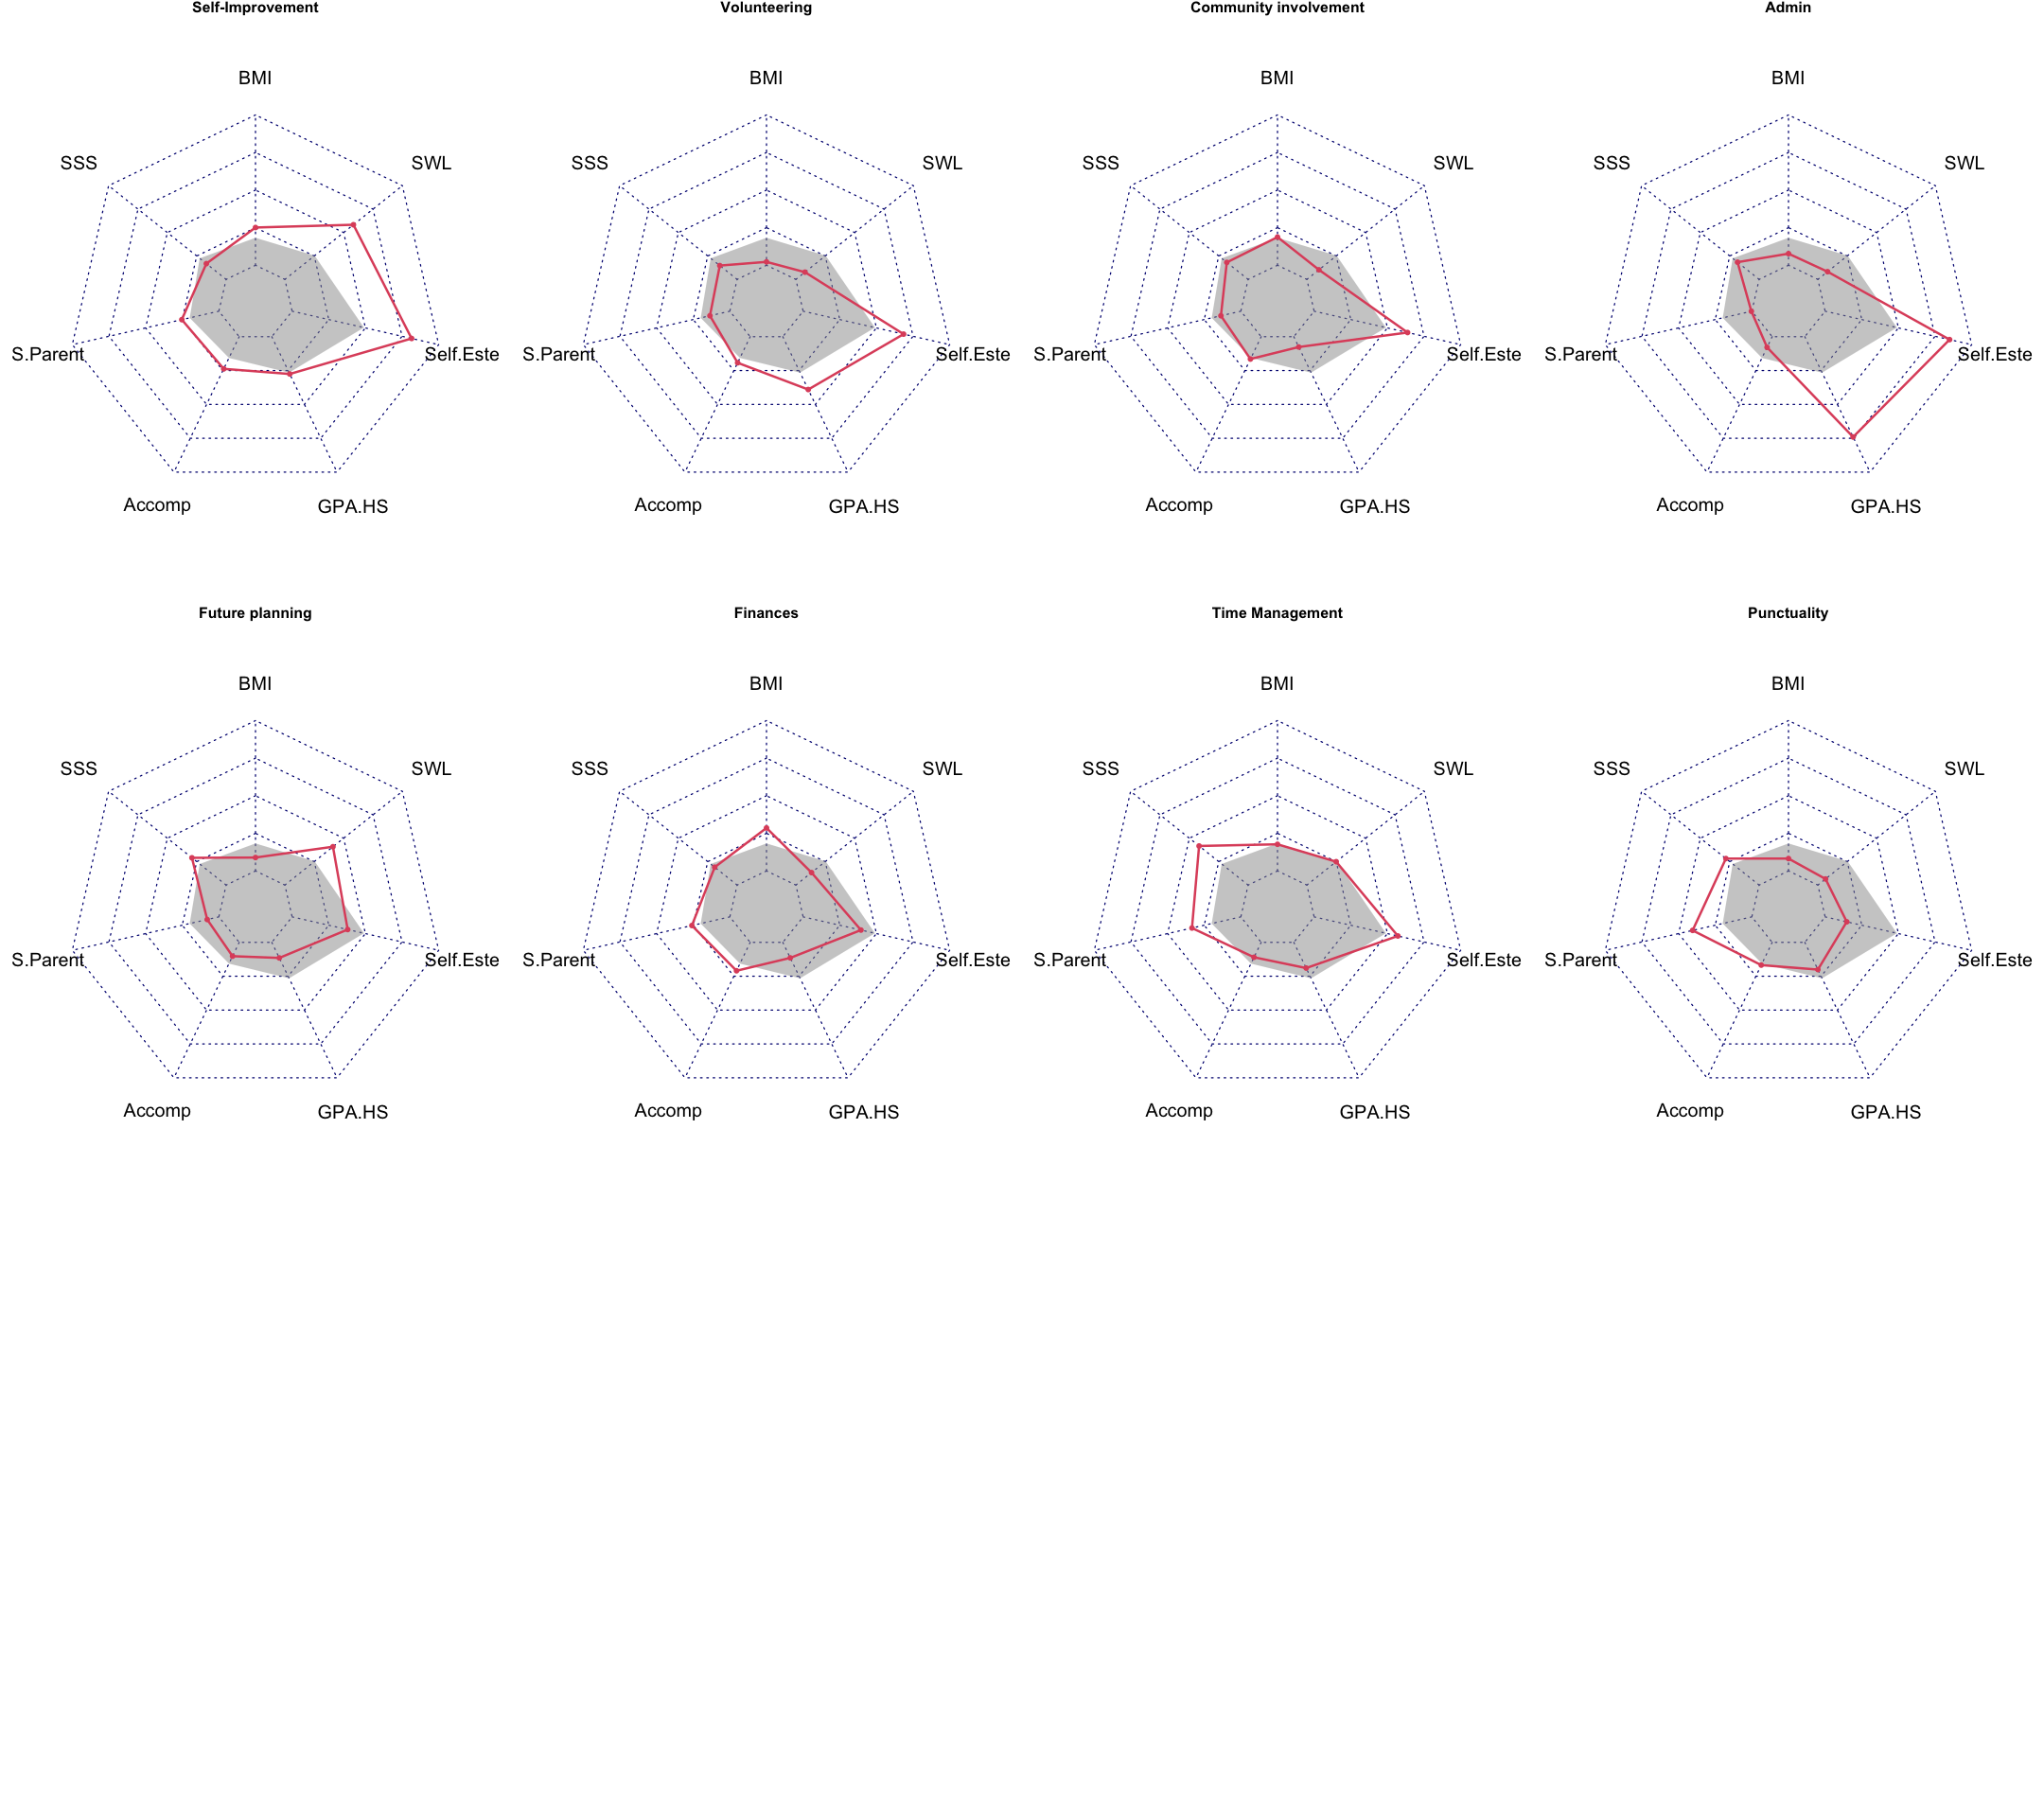

In [268]:
defaultW <- getOption("warn")
options(warn = -1)

options(repr.plot.width = 18, repr.plot.height = 16)

opar <- par() 
# Define settings for plotting in a 3x4 grid, with appropriate margins:
par(mar = rep(0.8,4))
par(mfrow = c(3,4))
# Produce a radar-chart for each student
for (i in 4:nrow(df)) {
  radarchart(
    df[c(1:3, i), ],
    pfcol = c("#99999980",NA),
    pcol= c(NA,2), plty = 1, plwd = 2,
    #title = row.names(df)[i],
    caxislabels = c(0, 0.1, 0.2, 0.3, 0.4, 0.5),
      vlcex = 1.5,
      calcex = 2
  )
    title(row.names(df)[i], cex = 2, col = 'red')
}
# Restore the standard par() settings
par <- par(opar) 

options(warn = defaultW)

# could consdier coloring dots red if negative and green if positive

### Lollipop

In [190]:
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [270]:
# make row name a column
df <- tibble::rownames_to_column(df_radar, "Domain")

In [271]:
df <- df %>%
  pivot_longer(
    cols = c(BMI, SSS, SSS.Parent, Accomp, GPA.HS, Self.Esteem, SWL),
    names_to = "Outcome",
    values_to = "Value"
  )
head(df)

Domain,Outcome,Value
<chr>,<chr>,<dbl>
Diet,BMI,0.05572838
Diet,SSS,0.15293076
Diet,SSS.Parent,0.06046989
Diet,Accomp,0.02401013
Diet,GPA.HS,0.17382193
Diet,Self.Esteem,0.20046165


#### Single

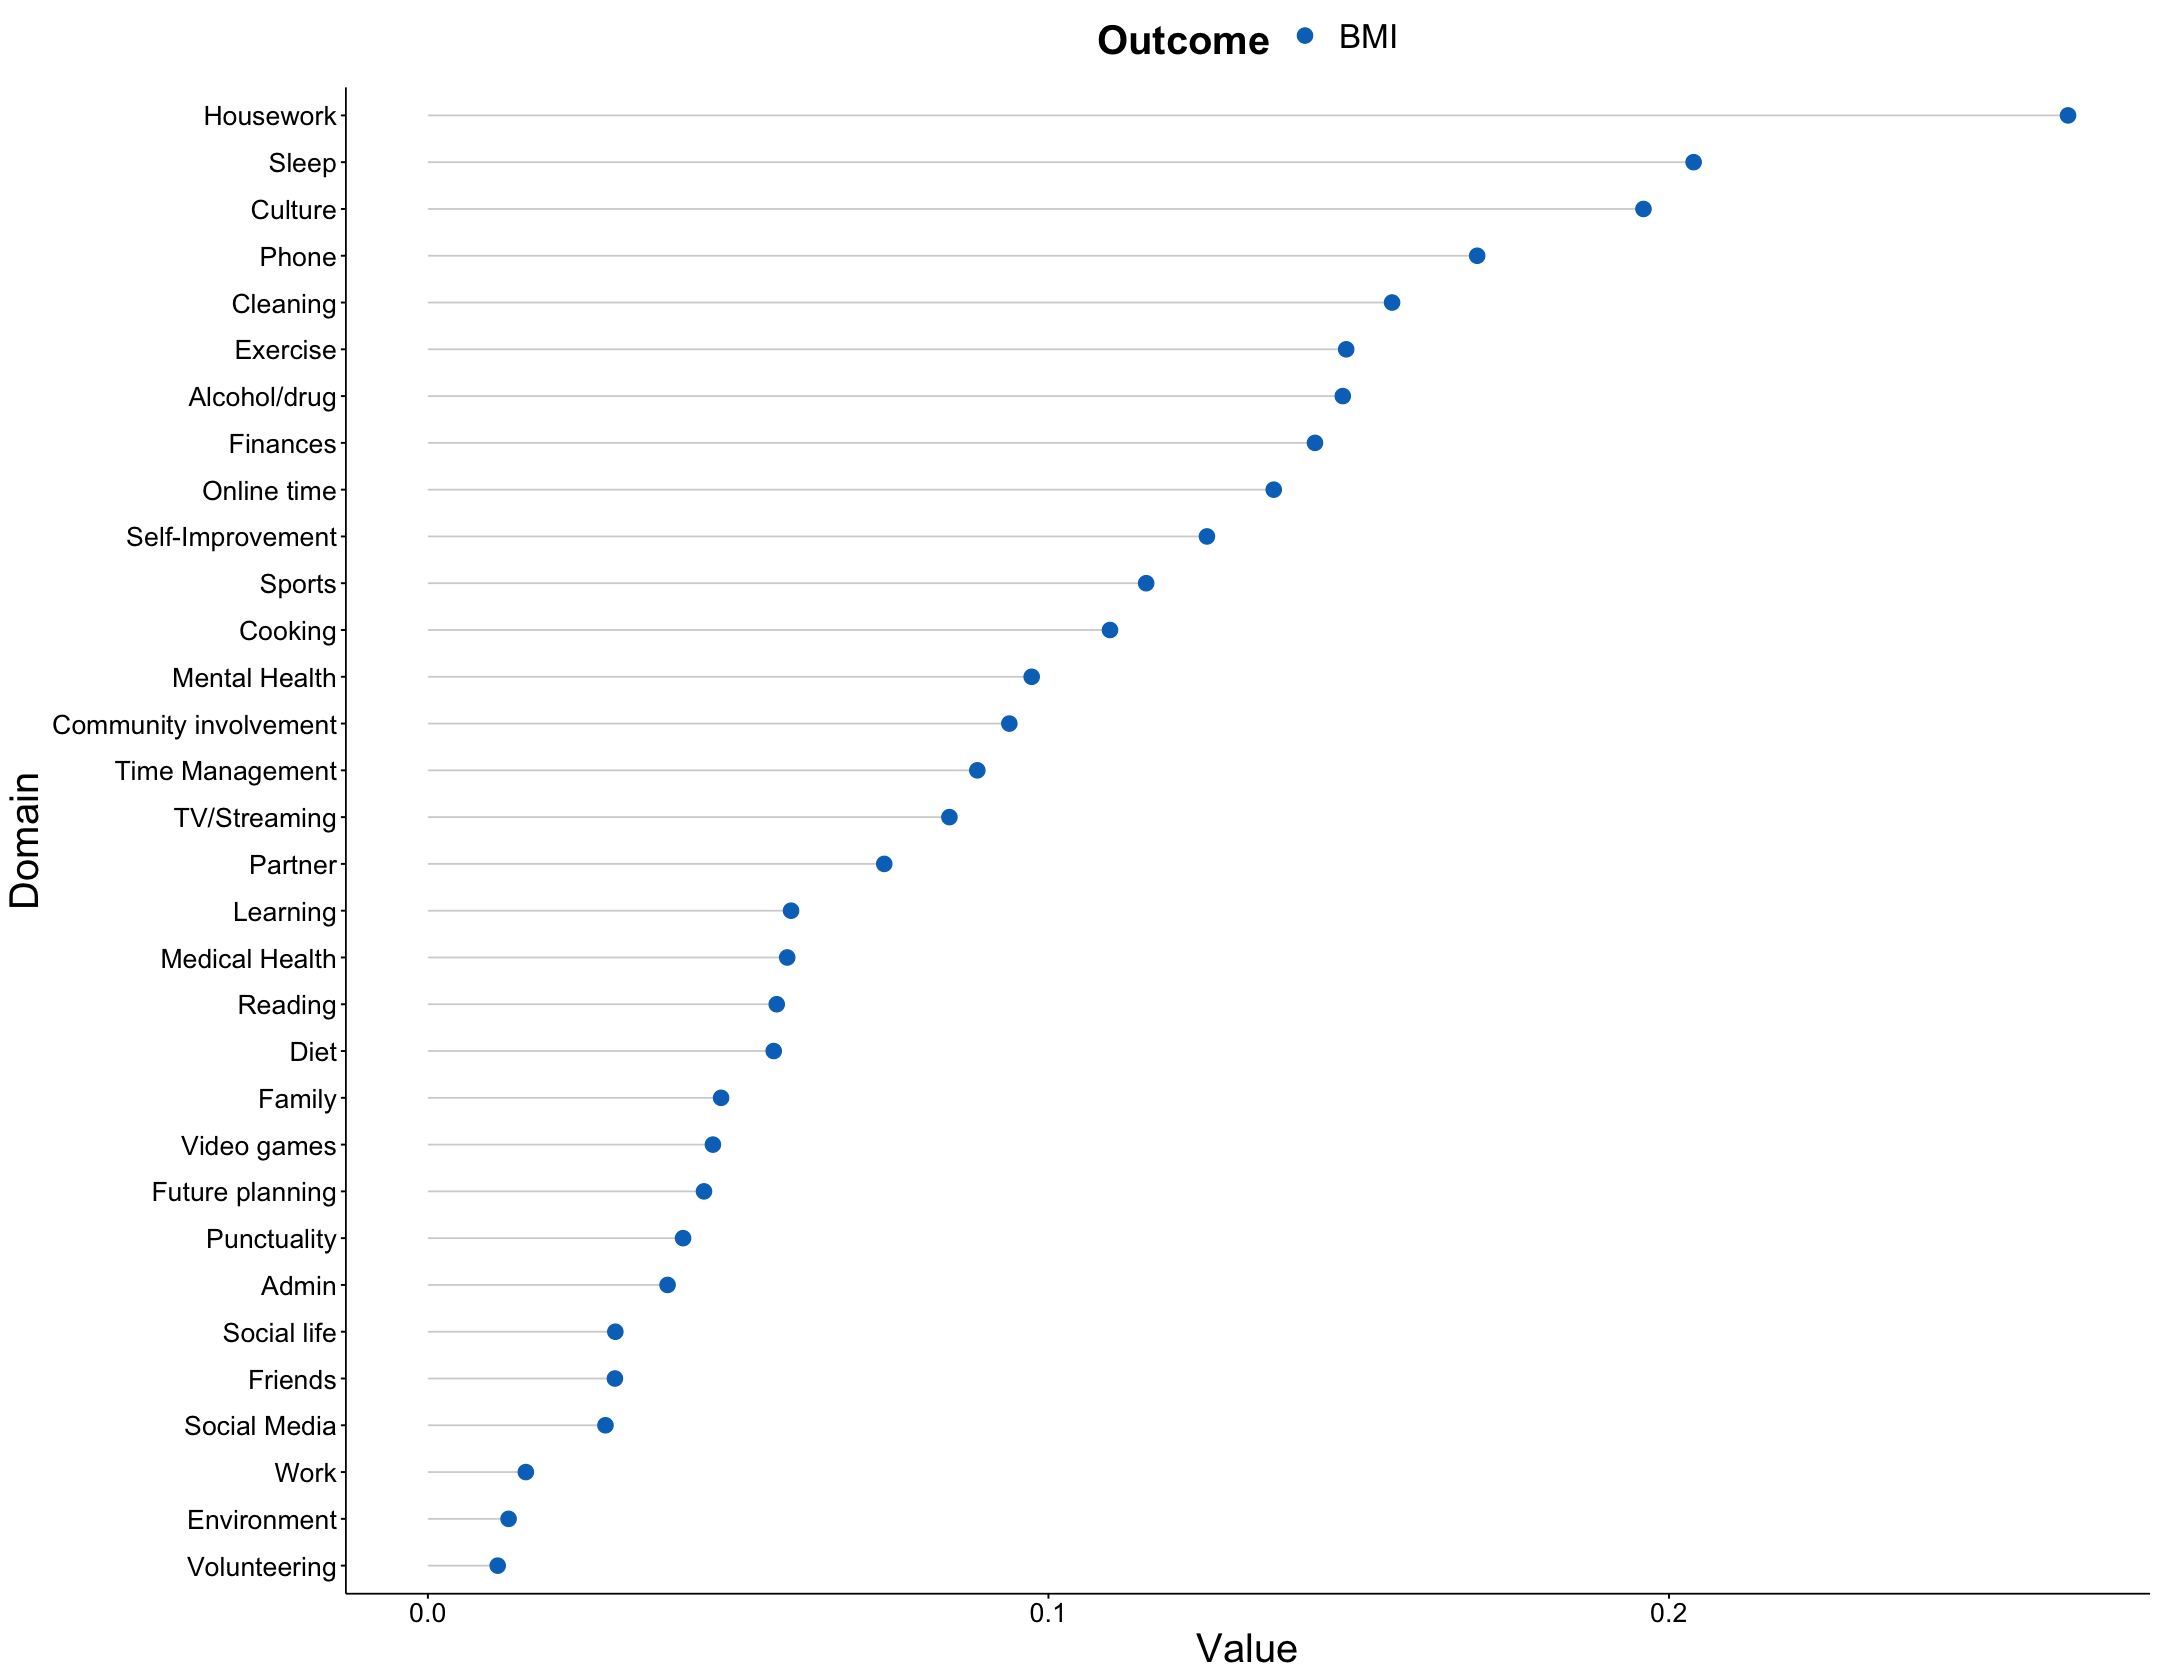

In [272]:
options(repr.plot.width = 18, repr.plot.height = 14)

ggdotchart(
  df[df$Outcome=='BMI', ], x = "Domain", y = "Value", 
  group = "Outcome", color = "Outcome", palette = "jco",
  add = "segment", position = position_dodge(0.5),
  sorting = "descending", #facet.by = "Outcome",
  rotate = TRUE, #, legend = "none"
    dot.size = 4
  ) +

 font("xlab", size = 24) + 
 font("ylab", size = 24) + 
 font("xy.text", size = 16) +
 font("legend.title", size = 24, face='bold') + 
 font("legend.text", size = 20)

#### All

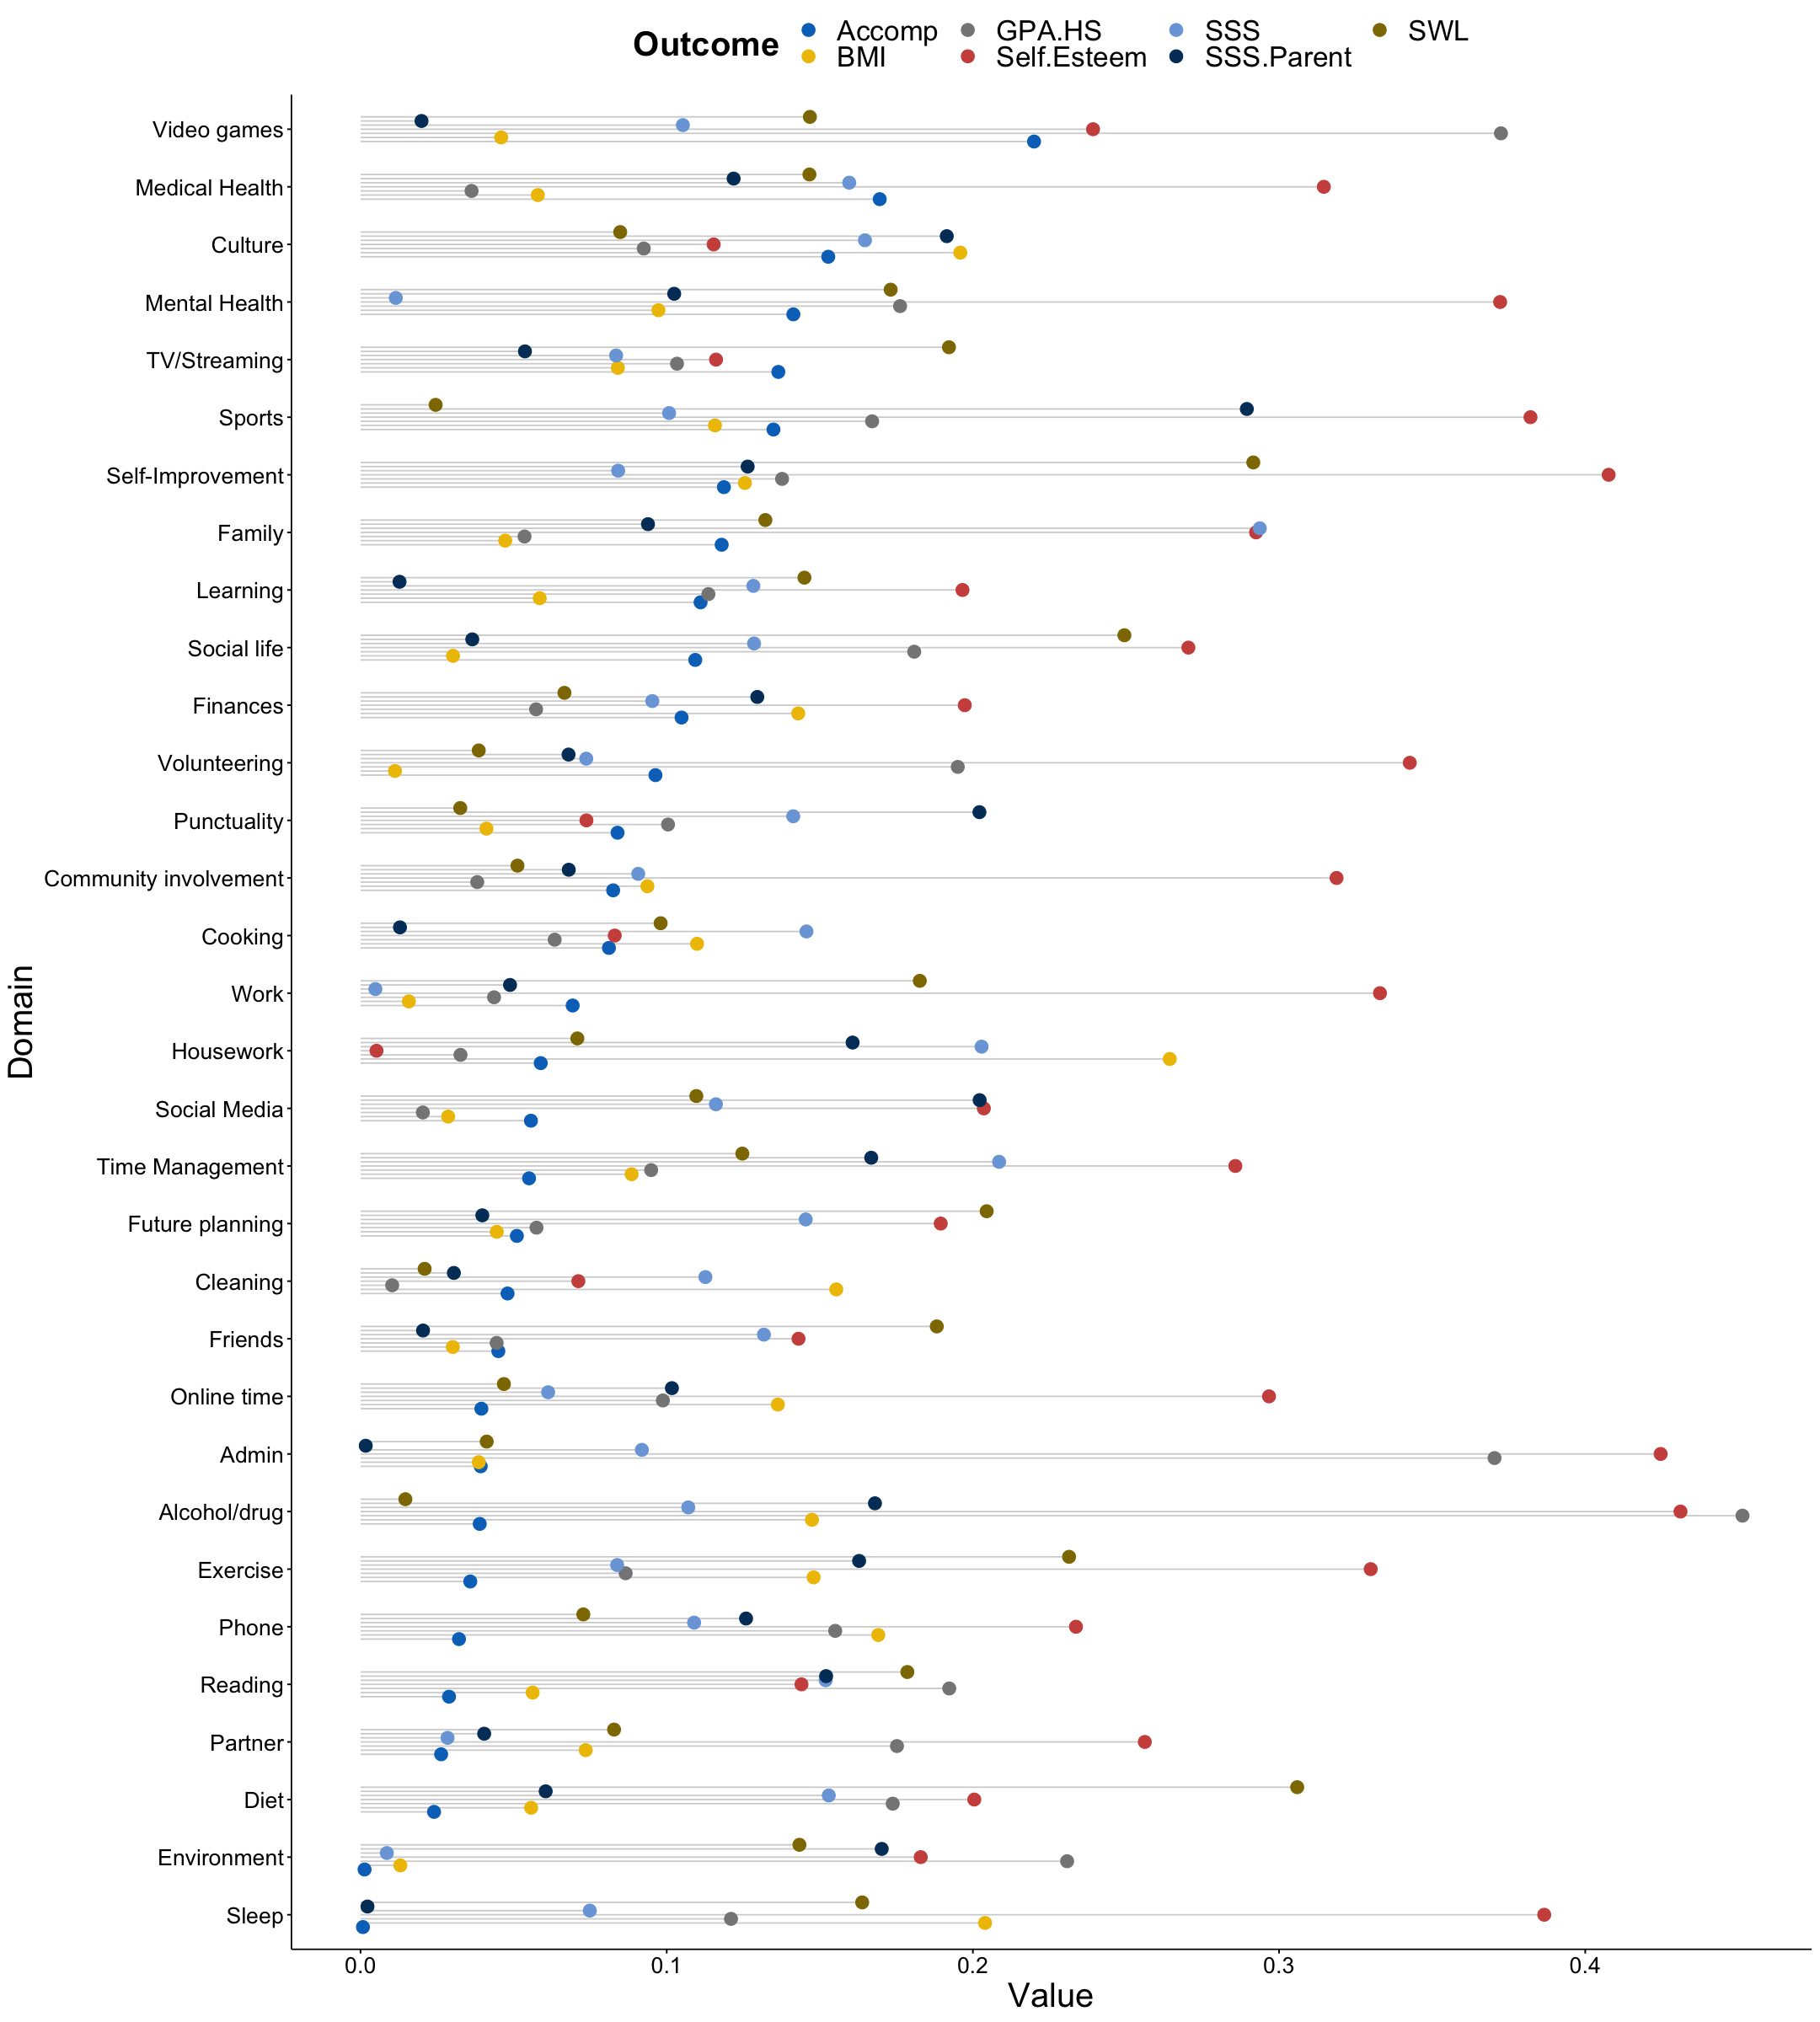

In [273]:
options(repr.plot.width = 18, repr.plot.height = 20)

ggdotchart(
  df, x = "Domain", y = "Value", 
  group = "Outcome", color = "Outcome", palette = "jco",
  add = "segment", position = position_dodge(0.5),
  sorting = "descending", #facet.by = "Outcome",
  rotate = TRUE, #, legend = "none"
    dot.size = 4
  ) +

 font("xlab", size = 24) + 
 font("ylab", size = 24) + 
 font("xy.text", size = 16) +
 font("legend.title", size = 24, face='bold') + 
 font("legend.text", size = 20)

## Locus of Motivation

In [217]:
names(scaled_domains_long)

[1] "domain_num"         "subjectID"          "domains_specific"  
 [4] "domains_success"    "domains_satis"      "domains_import"    
 [7] "domains_style"      "domains_internal"   "domains_external"  
[10] "domains_gapcause"   "domain_gap"         "w_domain_gap"      
[13] "domain_names"       "domain_names_short"

In [238]:
df = scaled_domains_long %>%
    group_by(domain_names_short) %>%
    summarise(internal = mean(domains_internal),
             external = mean(domains_external)) %>%
    arrange(desc(internal))

head(df, 3)

domain_names_short,internal,external
<chr>,<dbl>,<dbl>
Work,4.958716,4.302752
Family,4.903614,4.054217
Friends,4.778947,3.747368


In [239]:
df <- df %>%
  pivot_longer(
    cols = c(internal, external),
    names_to = "Locus",
    values_to = "Value"
  )
head(df)

domain_names_short,Locus,Value
<chr>,<chr>,<dbl>
Work,internal,4.958716
Work,external,4.302752
Family,internal,4.903614
Family,external,4.054217
Friends,internal,4.778947
Friends,external,3.747368


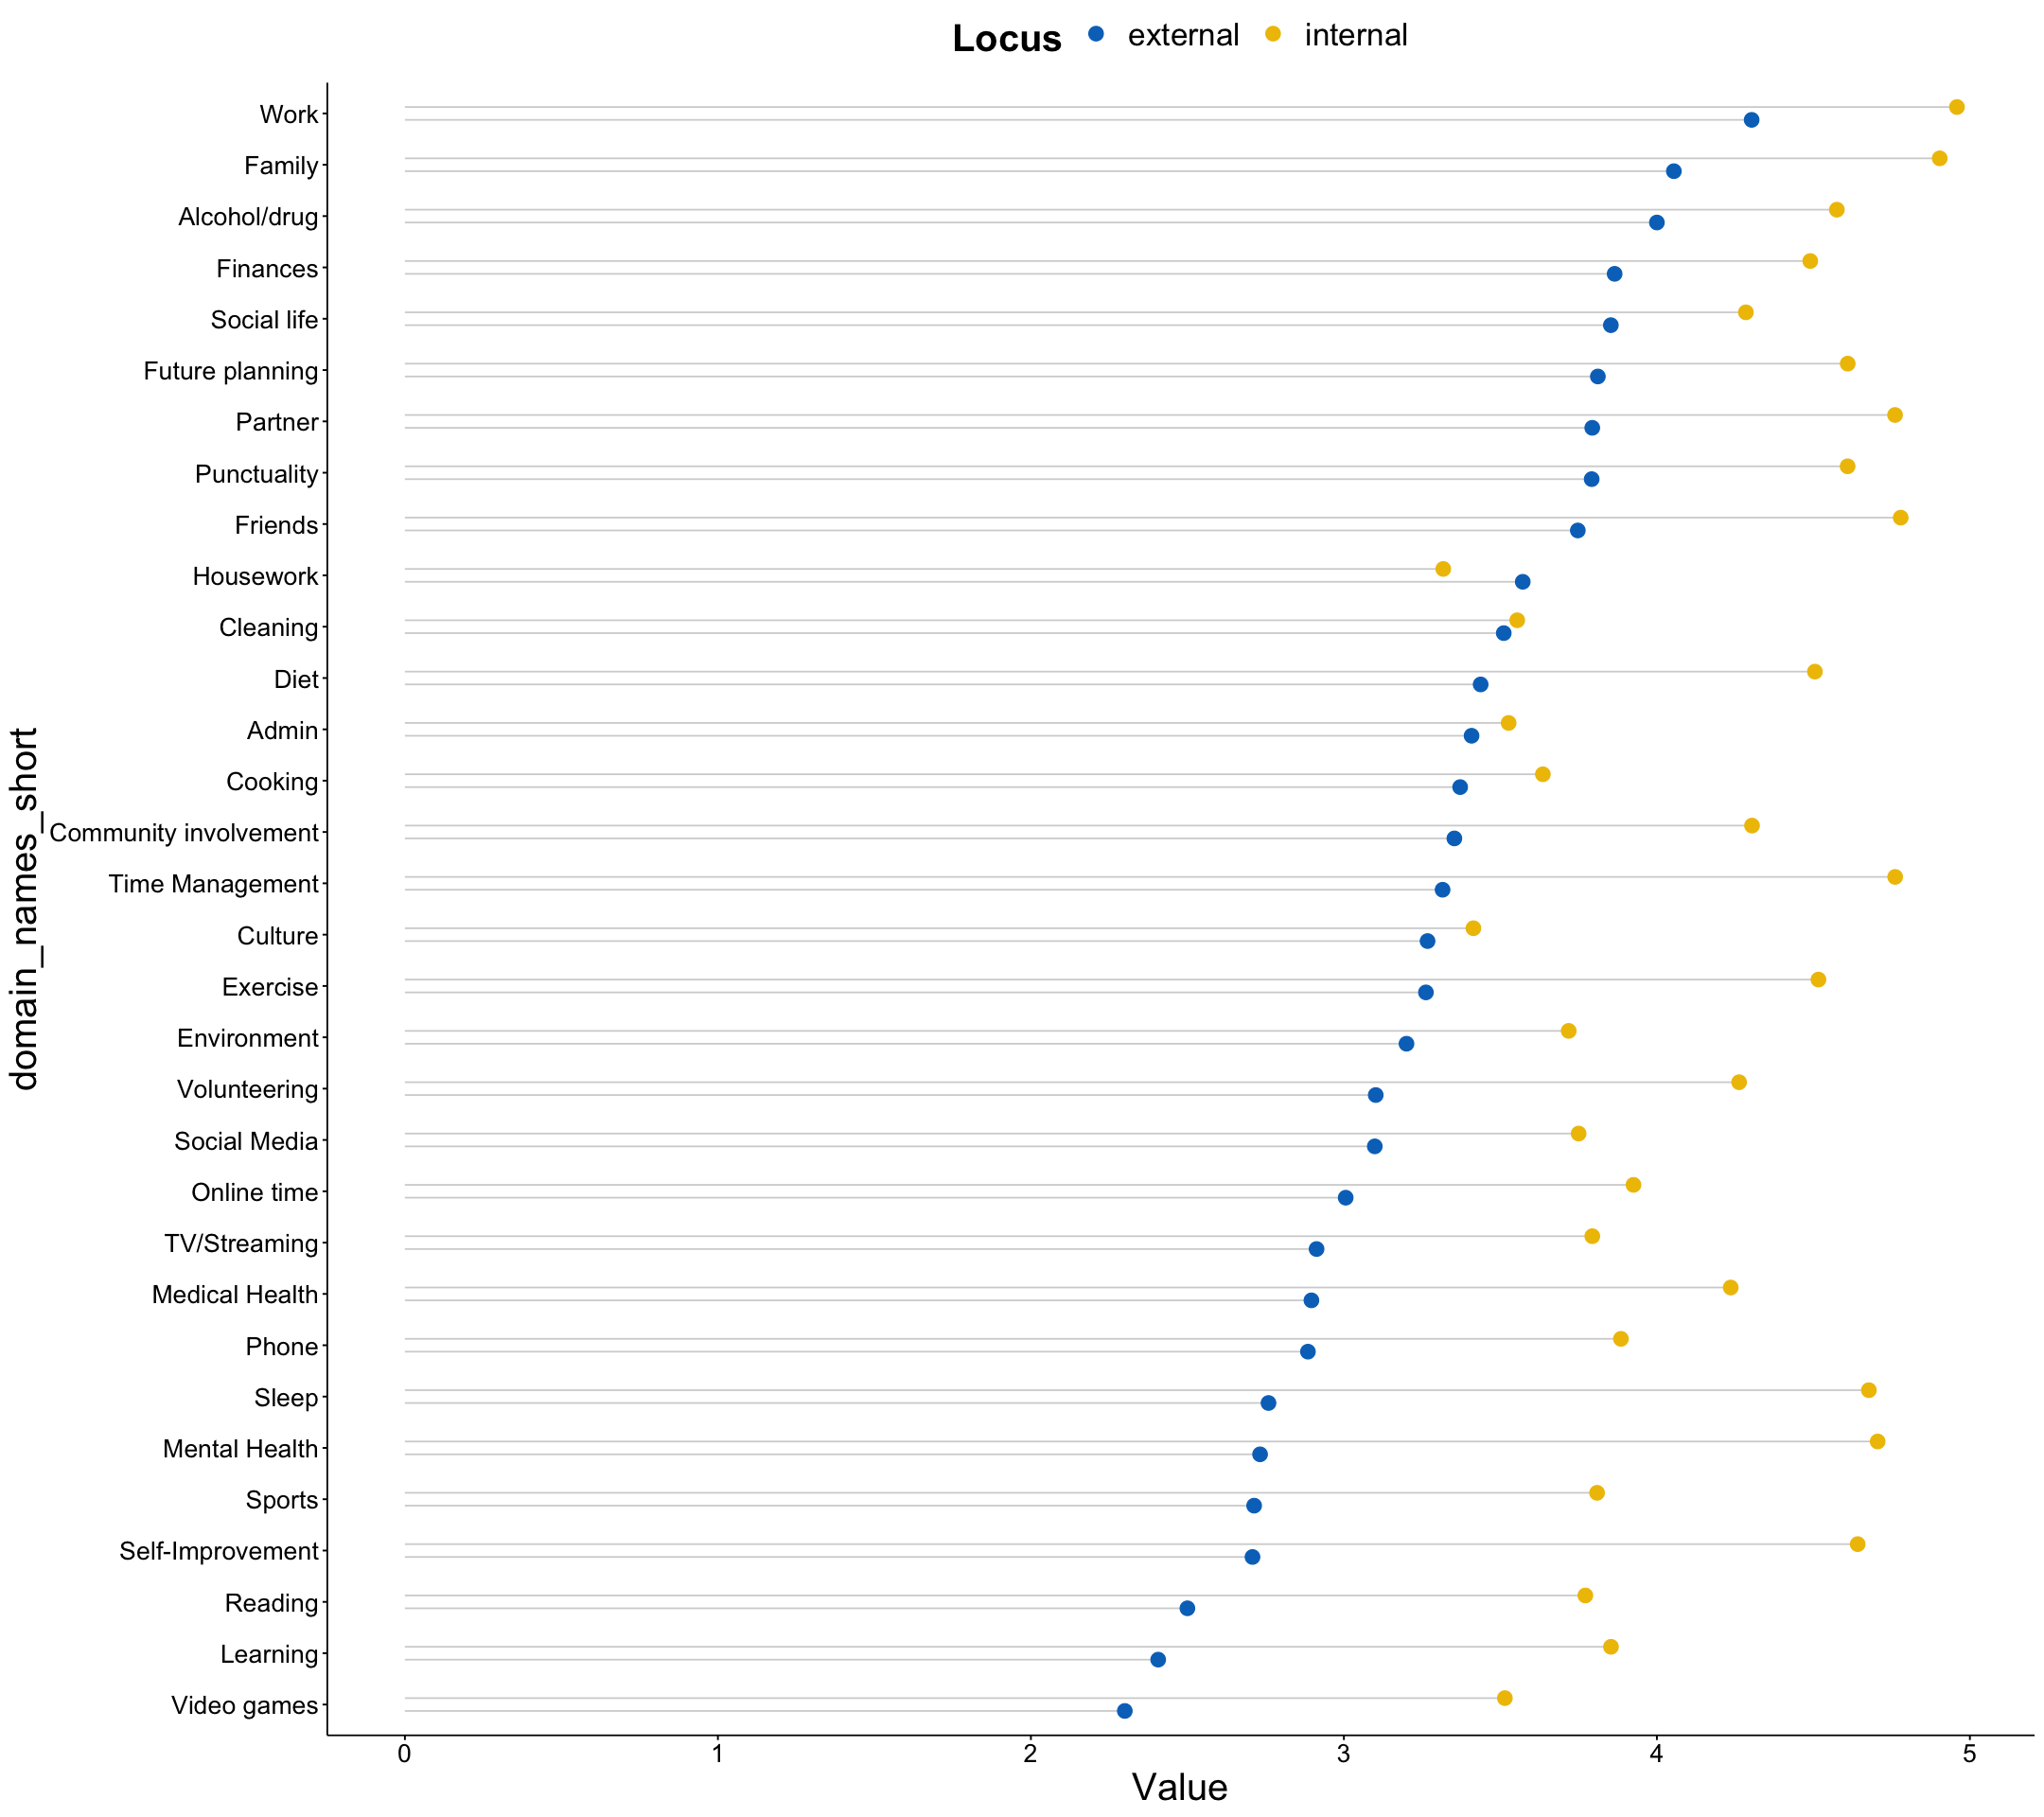

In [240]:
options(repr.plot.width = 18, repr.plot.height = 16)

ggdotchart(
  df, x = "domain_names_short", y = "Value", 
  group = "Locus", color = "Locus", palette = "jco",
  add = "segment", position = position_dodge(0.5),
  sorting = "descending", #facet.by = "Outcome",
  rotate = TRUE, #, legend = "none"
    dot.size = 4
  ) +

 font("xlab", size = 24) + 
 font("ylab", size = 24) + 
 font("xy.text", size = 16) +
 font("legend.title", size = 24, face='bold') + 
 font("legend.text", size = 20)

## Factor Analysis

### Kaiser-Meyer-Olkin test (KMO)

A Kaiser-Meyer-Olkin test (KMO) is used in research to determine the sampling adequacy of data that are to be used for Factor Analysis.

### PCA with missing data imputed

Use the `R` package `missMDA` dedicated to perform principal components methods with missing values and to impute data with PC methods.

- the number of components determined by `estim_ncpPCA`

### Pairwise Deletion of missing data